In [1]:
import pykite as pk
from utils import dql, dql_eval, plot_trajectory
from learning.deep.models import NN, NN5
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_attack=pk.coefficients.shape[0]
n_bank=pk.bank_angles.shape[0]
n_beta=pk.n_beta
gamma=1
eps0=0.01
eta0=0.0001
episode_duration=300
learning_step=0.2
horizon=int(episode_duration/learning_step)
integration_step=0.001
integration_steps_per_learning_step=int(learning_step/integration_step)

In [149]:
torch.manual_seed(71)
np.random.seed(1)
net=NN()
durations, rewards,_,_,_=dql(net, 'sgd', 1000, horizon, learning_step, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/6, 0, 50), pk.vect(0, 0, 0), 10, lr_decay_start=250000, eps_decay_start=250000, eps_decay_exp=1.3, lr_decay_exp=0.9, eps=eps0, lr=eta0)
#durations, rewards,theta,phi,r=dql(net, 'adam', 1000, horizon, learning_step, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/6, 0, 50), pk.vect(0, 0, 0), 10, lr_decay_start=10000000, eps_decay_start=10000000, eps_decay_exp=1.3, lr_decay_exp=0.9, eps=eps0, lr=eta0, plot=True)


0
Simulation ended at learning step:  1499  reward  2.1822413324012464
1
epsilon  0.05  eta 0.0001 Simulation failed at learning step:  1145  reward  0.9062627731005873
2
epsilon  0.05  eta 0.0001 Simulation failed at learning step:  914  reward  0.5991283964963795
3
epsilon  0.01  eta 0.0001 Simulation failed at learning step:  2  reward  -3.0
4
Simulation ended at learning step:  1499  reward  1.694116180302983
5
Simulation ended at learning step:  1499  reward  2.7082680975167794
6
Simulation ended at learning step:  1499  reward  1.8885663277025155
7
Simulation ended at learning step:  1499  reward  2.158763811231278
8
Simulation ended at learning step:  1499  reward  2.625072085966081
9
Simulation ended at learning step:  1499  reward  2.5929004506205877
10
Simulation ended at learning step:  1499  reward  1.7638489614144441
11
epsilon  0.05  eta 0.0001 Simulation failed at learning step:  940  reward  1.9251172188203383
12
epsilon  0.05  eta 0.0001 Simulation failed at learning s

In [148]:
def dql(net, opt, episodes, horizon, learning_step, integration_step, integration_steps_per_learning_step, initial_pos, initial_vel, wind, lr=0.1, lr_decay_exp=0.6, lr_decay_start=200000, eps=0.01, eps_decay_exp=0.6, eps_decay_start=400000, gamma=1, plot=False):
    durations=[]
    rewards=[]
    losses=[]
    if opt=='adam':
        optimizer=torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.000)
    else:
        optimizer=torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.000)
    loss=torch.nn.SmoothL1Loss()
    t=0
    k=pk.kite(initial_pos, initial_vel)
    for episode in range(episodes):
        print(episode)
        k.reset(initial_pos, initial_vel)
        t,theta,phi,r=dql_episode(k, net, optimizer, loss, initial_pos, initial_vel, wind, horizon, learning_step, integration_step, integration_steps_per_learning_step, lr, lr_decay_exp, lr_decay_start, eps, eps_decay_exp, eps_decay_start, durations, rewards, gamma, t, plot)
    return durations, rewards,theta,phi,r

def dql_episode(k, net, optimizer, loss, initial_position, initial_velocity, wind, horizon, learning_step, integration_step, integration_steps_per_learning_step, eta0, eta_decay, eta_decay_start, eps0, eps_decay, eps_decay_start, durations, rewards, gamma, t, plot):
    if plot:
        theta=[]
        phi=[]
        r=[]
    else:
        theta=None
        phi=None
        r=None
    cumulative_reward=0
    factor=1e6
    initial_beta=k.beta()
    S_t=(np.random.randint(0,n_attack), np.random.randint(0,n_bank), initial_beta)
    k.C_l, k.C_d = pk.coefficients[S_t[0],0], pk.coefficients[S_t[0],1]
    k.psi = np.deg2rad(pk.bank_angles[S_t[1]])
    acc=k.accelerations()
    S_t+=acc
    tensor_state=torch.tensor(S_t).float()
    tensor_state[0]/=n_attack
    tensor_state[1]/=n_bank
    tensor_state[2]/=n_beta
    for i in range(horizon):
        '''
        if k.position.r*np.cos(k.position.theta)>100:
            print(k.position.r*np.cos(k.position.theta))
            print(k.position.r)
            break
        '''
        if plot:
            theta.append(k.position.theta)
            phi.append(k.position.phi)
            r.append(k.position.r)
        t+=1
        eps=scheduling(eps0, t, eps_decay_start, exp=eps_decay)
        if i<300:
            eps=eps*1
        else:
            eps=eps*5
        q=net(tensor_state).reshape(3,3)
        A_t=torch.randint(3,(2,)) if np.random.rand()<eps else (q==torch.max(q)).nonzero().reshape(-1)
        A_t=A_t[0],A_t[1]
        optimizer.param_groups[0]['lr']=scheduling(eta0, t, eta_decay_start, exp=eta_decay)
        new_attack_angle, new_bank_angle=apply_action(S_t, A_t)
        sim_status=k.evolve_system(new_attack_angle, new_bank_angle, integration_steps_per_learning_step, integration_step)
        if not sim_status==0:
            R_t1 = scheduling(-3000000.0/factor, i, horizon/4)
            cumulative_reward+=R_t1
            rewards.append(cumulative_reward)
            durations.append(i)
            target=torch.tensor(R_t1)
            l=loss(target, q[A_t])
            print("epsilon ", eps, " eta", optimizer.param_groups[0]['lr'], "Simulation failed at learning step: ", i, " reward ", cumulative_reward)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            break
        S_t1 = (new_attack_angle, new_bank_angle, k.beta())
        acc=k.accelerations()
        S_t1+=acc
        tensor_state=torch.tensor(S_t1).float()
        tensor_state[0]/=n_attack
        tensor_state[1]/=n_bank
        tensor_state[2]/=n_beta
        R_t1 = k.reward(learning_step)/factor
        cumulative_reward+=R_t1 
        if i==int(horizon)-1:
            print("Simulation ended at learning step: ", i, " reward ", cumulative_reward)
            target=torch.tensor(R_t1)
            rewards.append(cumulative_reward)
            durations.append(i)
        else:
            target=R_t1+gamma*torch.max(net(tensor_state))
        l=loss(target, q[A_t])
        S_t=S_t1
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    return t,theta,phi,r

In [69]:
_, _ ,theta1,phi1,r1=dql(net, 'adam', 1, horizon, learning_step, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/6, 0, 50), pk.vect(0, 0, 0), 10, lr_decay_start=np.inf, eps_decay_start=np.inf, eps_decay_exp=1.3, lr_decay_exp=0.9, eps=1e-9, lr=0, plot=True)

0
Simulation ended at learning step:  1499  reward  180.2816830814085


In [4]:
from utils import *

[0.52359878 0.51803491 0.52196767 ... 1.54163089 1.54218096 1.5428998 ] [0.         0.02202308 0.07275953 ... 0.08487743 0.08400961 0.08459269] [  50.           50.54031942   51.1169854  ... 4527.90813965 4531.12649386
 4534.42931752]


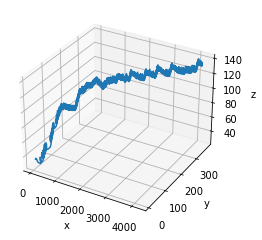

In [140]:
theta1=np.array(theta1)
phi1=np.array(phi1)
r1=np.array(r1)
print(theta, phi, r)
plot_trajectory(theta1[::1], phi1[::1], r1[::1])

In [138]:
_, _ ,theta1,phi1,r1=dql(net, 'adam', 1, horizon, learning_step, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/4, np.pi/12, 50), pk.vect(0, 0, 0), 10, lr_decay_start=np.inf, eps_decay_start=np.inf, eps_decay_exp=1.3, lr_decay_exp=0.9, eps=1e-9, lr=0, plot=True)

0
Simulation ended at learning step:  1499  reward  154.86696902196877


In [158]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


In [181]:
print(x[149], y[149], z[149])

263.2665240710835 61.75001594706416 89.26750028859423


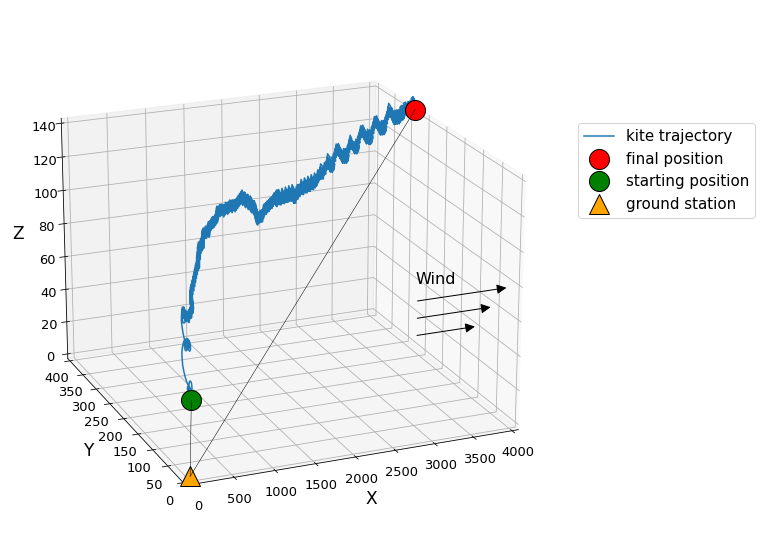

In [191]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -112.5)

startpoint = 0

maxdata_plot = 180


rail = np.zeros((3, 2))
rail[0][0] = 0
rail[0][1] = 600
#line2, = ax.plot(rail[0, 0:2], rail[1, 0:2], rail[2, 0:2], color='black', linewidth=0.7, label = 'rail')
line, = ax.plot(x[::1], y[::1], z[::1], label = 'kite trajectory')
#line1, = ax.plot(new_traj[startpoint:maxdata_plot, 9], new_traj[startpoint:maxdata_plot, 10], 
                 #new_traj[startpoint:maxdata_plot, 11], label = 'block')


ax.set_ylim(0, 400)
ax.set_xlim(0, 4000)
ax.set_zlim(0, 140)
ax.set_xlabel('X', fontsize=17, labelpad=10)
ax.set_ylabel('Y', fontsize=17, labelpad=10)
ax.set_zlabel('Z', fontsize=17, labelpad=10)
#ax.legend(fontsize=14, bbox_to_anchor=(0.47, -0.3, 0.5, 0.5))

ax.tick_params(axis='both', which='major', labelsize=13)
#ax.set_xticks([550, 600, 650, 700])
#ax.set_yticks([-10, 0, 10])
#ax.set_zticks([0, 10, 20, 30, 40])

#cubo = parse_path("""m 24.3987,286.07448 c -0.125335,-0.0506 -0.15875,-2.44886 -0.15875,-11.39393 v -11.32988 l 4.300252,-1.35954 4.300251,-1.35954 h 19.438363 c 10.691099,0 19.528761,0.0347 19.639249,0.0771 0.181097,0.0695 0.200887,1.18879 0.200887,11.36203 0,10.6183 -0.01313,11.29186 -0.22225,11.40202 -0.122238,0.0644 -2.056827,0.69506 -4.299089,1.40147 l -4.076839,1.28439 -19.481662,-0.01 C 33.324198,286.1426 24.486013,286.1098 24.3987,286.0745 Z m 38.830252,-1.50339 v -1.0795 H 48.139405 33.049858 l -3.230204,1.01731 c -1.776612,0.55953 -3.287354,1.04079 -3.357204,1.06948 -0.06985,0.0287 8.174038,0.0567 18.319751,0.0622 l 18.446751,0.01 z m -34.417002,-0.36169 3.7465,-1.18324 0.03255,-9.60979 0.03255,-9.60978 H 28.685749 24.74795 v 10.795 c 0,8.55239 0.03298,10.79459 0.15875,10.79303 0.08731,-10e-4 1.844675,-0.53444 3.90525,-1.18522 z m 38.013709,0.29598 c 1.549236,-0.49017 2.873943,-0.91428 2.943793,-0.94248 0.06985,-0.0282 -1.258888,-0.0558 -2.95275,-0.0613 l -3.07975,-0.01 v 0.9525 c 0,0.59217 0.05143,0.9525 0.135957,0.9525 0.07478,0 1.403514,-0.40105 2.95275,-0.89121 z m -3.596707,-11.11029 v -9.5885 H 48.179451 33.12995 v 9.5885 9.5885 h 15.049501 15.049501 z m 8.382,-1.2065 c 0,-8.5532 -0.03297,-10.79427 -0.15875,-10.79149 -0.08731,0.002 -1.844675,0.5396 -3.90525,1.19483 l -3.7465,1.19133 -0.03255,9.60017 -0.03255,9.60016 h 3.937798 3.937799 z m -38.989002,-9.8425 c 0,-0.52387 -0.04722,-0.9525 -0.10493,-0.9525 -0.09257,0 -5.603272,1.70542 -5.92757,1.83443 -0.06985,0.0278 1.258888,0.055 2.95275,0.0605 l 3.07975,0.01 z m 33.993901,-0.0795 c 1.804331,-0.56762 3.304413,-1.05339 3.333518,-1.0795 0.0291,-0.0261 -8.24336,-0.0475 -18.383251,-0.0475 H 33.12995 v 1.0795 1.0795 h 15.102651 15.10265 z""")
#cubo.vertices -= cubo.vertices.mean(axis=0)

ax.plot(x[-1],y[-1],z[-1],
        markerfacecolor='red', markeredgecolor='k', marker = "o", markersize=20, label='final position', linestyle='None')
ax.plot(x[0],y[0],z[0],
        markerfacecolor='green', markeredgecolor='k', marker = "o", markersize=20, label='starting position', linestyle='None')

ax.plot(0,0,0,
        markerfacecolor='orange', markeredgecolor='k', marker = "^", markersize=20, label='ground station', linestyle='None')

#ax.plot(new_traj[0:1, 0], 
        #new_traj[0:1, 1], 
        #new_traj[0:1, 2],
        #markerfacecolor='blue', markeredgecolor='k', marker = "o", markersize=8, alpha=0.5)

#ax.plot(new_traj[0:1, 9], 
        #new_traj[0:1, 10], 
        #new_traj[0:1, 11],
        #markerfacecolor='orange', markeredgecolor='k', marker = "s", markersize=8, alpha=0.5)
a = Arrow3D([3000, 4000], [50, 50], [60, 60], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
b = Arrow3D([3000, 3800], [50, 50], [50, 50], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
c = Arrow3D([3000, 4200], [50, 50], [70, 70], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")

ax.add_artist(a)
ax.add_artist(b)
ax.add_artist(c)
#ax.arrow(3,1,-0.89,0, length_includes_head=True,head_width=0.1, head_length=0.05, color="black")
#ax.annotate("", xy=(-0.07, 2.07), xytext=(0.95, 1.05), arrowprops=dict(arrowstyle="<->"))
ax.text(3000,50,80, "Wind", size=16)
ax.plot([x[0],0],
        [y[0], 0], 
        [z[0], 0], color = 'black', linewidth = .5)
ax.plot([0, x[-1]],
        [0, y[-1]], 
        [0, z[-1]], color = 'black', linewidth = .5)

ax.legend(fontsize=15, bbox_to_anchor=(0.89, 0.3, 0.5, 0.5))
plt.savefig("3d_trajectory_frame.png", bbox_inches='tight', dpi=200)
plt.show()


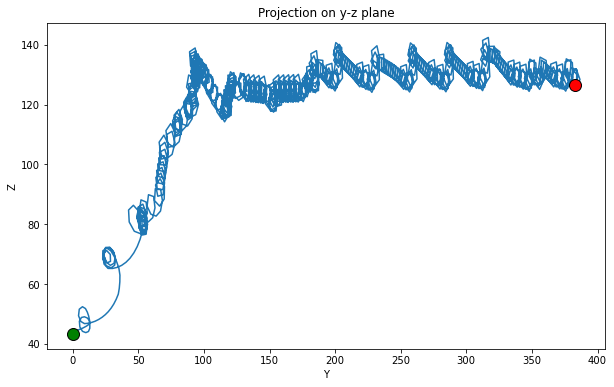

In [124]:
plt.figure(figsize=(10,6))
plt.title("Projection on y-z plane")
plt.plot(y[::1],z[::1])
plt.ylabel("Z")
plt.xlabel("Y")
plt.plot(y[-1],z[-1],
        markerfacecolor='red', markeredgecolor='k', marker = "o", markersize=12, label='final position', linestyle='None')
plt.plot(y[0],z[0],
        markerfacecolor='green', markeredgecolor='k', marker = "o", markersize=12, label='starting position', linestyle='None')
plt.savefig("yz.png", bbox_inches='tight', dpi=200)

In [189]:
max(y)

386.608501898163

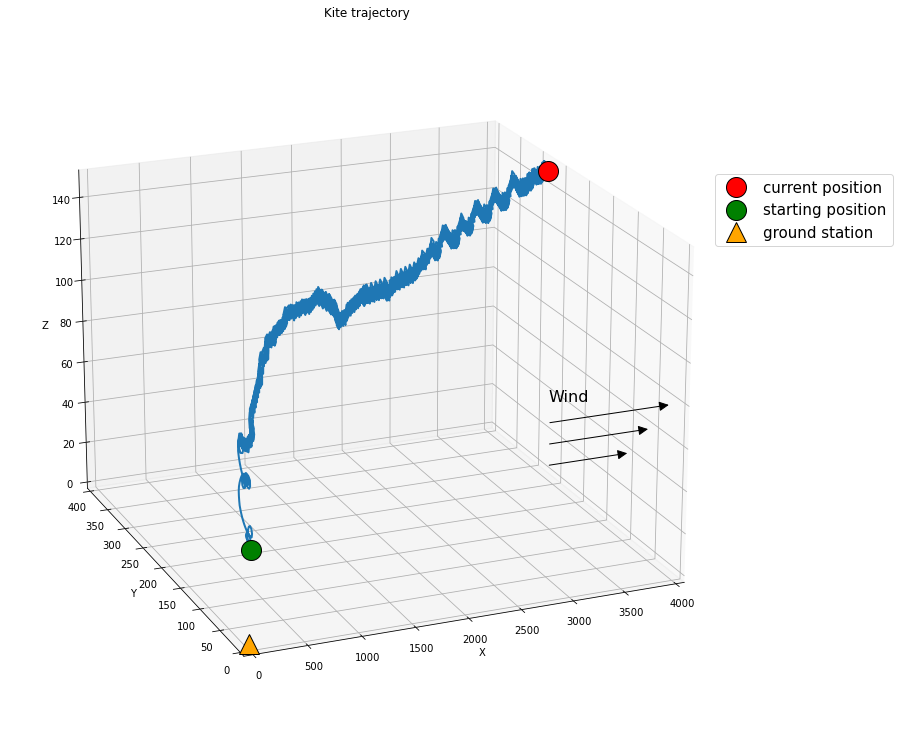

In [190]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# References
# https://gist.github.com/neale/e32b1f16a43bfdc0608f45a504df5a84
# https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c
# https://riptutorial.com/matplotlib/example/23558/basic-animation-with-funcanimation

# ANIMATION FUNCTION
def func(num, dataSet, line,redDots):
    # NOTE: there is no .set_data() for 3 dim data...
    line.set_data(dataSet[0:2, :num])
    line.set_3d_properties(dataSet[2, :num])
    redDots.set_data(dataSet[0:2, num-1])    
    redDots.set_3d_properties(dataSet[2, num-1]) 
    '''
    if num>0:
        vect=np.ones(num)*100
        vect[-1]=1
        redDots.set_data(dataSet[0:2, :num])    
        redDots.set_3d_properties(np.multiply(dataSet[2, :num], vect)) 
    else:
        redDots.set_data(dataSet[0:2, :num])    
        redDots.set_3d_properties(dataSet[2, :num])
    '''
    return line
 
 
# THE DATA POINTS

dataSet = np.array([x, y, z])
numDataPoints = len(z)
 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure(figsize=(16, 10))
ax = Axes3D(fig)
ax.view_init(20, -112.5)


ax.set_ylim(0, 400)
ax.set_xlim(0, 4000)
ax.set_zlim(0, 150)
line = ax.plot(dataSet[0], dataSet[1], dataSet[2], '-', lw=2)[0] # For line plot
redDots = plt.plot(dataSet[0], dataSet[1], dataSet[2], markerfacecolor='red', markeredgecolor='k', marker = "o", markersize=20, label='current position', linestyle='None')[0]
# NOTE: Can't pass empty arrays into 3d version of plot()

 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Kite trajectory')
a = Arrow3D([3000, 4000], [50, 50], [60, 60], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
b = Arrow3D([3000, 3800], [50, 50], [50, 50], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
c = Arrow3D([3000, 4200], [50, 50], [70, 70], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")

ax.add_artist(a)
ax.add_artist(b)
ax.add_artist(c)
#ax.arrow(3,1,-0.89,0, length_includes_head=True,head_width=0.1, head_length=0.05, color="black")
#ax.annotate("", xy=(-0.07, 2.07), xytext=(0.95, 1.05), arrowprops=dict(arrowstyle="<->"))
ax.text(3000,50,80, "Wind", size=16)
#ax.plot(x[-1],y[-1],z[-1],
        #markerfacecolor='red', markeredgecolor='k', marker = "o", markersize=20, label='final position', linestyle='None')
ax.plot(x[0],y[0],z[0],
        markerfacecolor='green', markeredgecolor='k', marker = "o", markersize=20, label='starting position', linestyle='None')

ax.plot(0,0,0,
        markerfacecolor='orange', markeredgecolor='k', marker = "^", markersize=20, label='ground station', linestyle='None')
ax.legend(fontsize=15, bbox_to_anchor=(0.74, 0.3, 0.5, 0.5))
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, func, frames=numDataPoints, fargs=(dataSet,line,redDots), interval=30, blit=False)
line_ani.save(r'dql_lin.mp4')

 
plt.show()

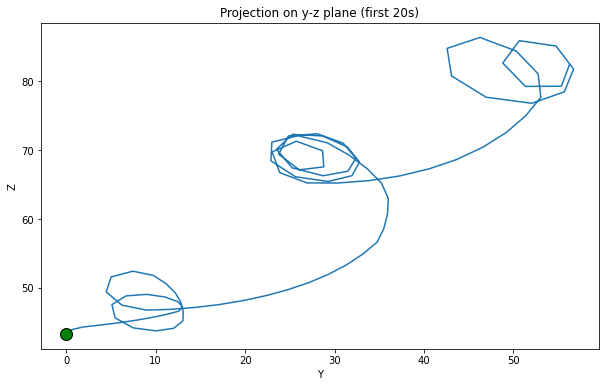

In [125]:
plt.figure(figsize=(10,6))
plt.title("Projection on y-z plane (first 20s)")
plt.plot(y[:100:1],z[:100:1])
plt.ylabel("Z")
plt.xlabel("Y")
plt.plot(y[0],z[0],
        markerfacecolor='green', markeredgecolor='k', marker = "o", markersize=12, label='starting position', linestyle='None')
plt.savefig("yz_init.png", bbox_inches='tight', dpi=200)

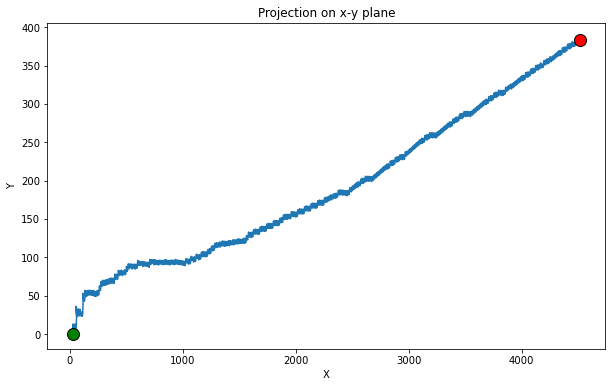

In [134]:
plt.figure(figsize=(10,6))
plt.title("Projection on x-y plane")
plt.plot(x[::1],y[::1])
plt.ylabel("Y")
plt.xlabel("X")
plt.plot(x[-1],y[-1],
        markerfacecolor='red', markeredgecolor='k', marker = "o", markersize=12, label='final position', linestyle='None')
plt.plot(x[0],y[0],
        markerfacecolor='green', markeredgecolor='k', marker = "o", markersize=12, label='starting position', linestyle='None')
plt.savefig("xy.png", bbox_inches='tight', dpi=200)

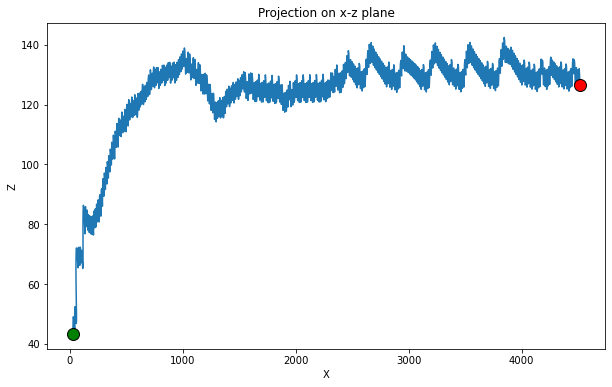

In [127]:
plt.figure(figsize=(10,6))
plt.title("Projection on x-z plane")
plt.plot(x[::1],z[::1])
plt.ylabel("Z")
plt.xlabel("X")
plt.plot(x[-1],z[-1],
        markerfacecolor='red', markeredgecolor='k', marker = "o", markersize=12, label='final position', linestyle='None')
plt.plot(x[0],z[0],
        markerfacecolor='green', markeredgecolor='k', marker = "o", markersize=12, label='starting position', linestyle='None')
plt.savefig("xz.png", bbox_inches='tight', dpi=200)

In [142]:
for p in net.named_parameters():
    print(p)

('layer1.weight', Parameter containing:
tensor([[ 0.0036, -0.1374,  0.3832,  0.2256,  0.3785,  0.0052],
        [ 0.3051, -0.0755,  0.1131, -0.0705,  0.2527,  0.1224],
        [ 0.3986,  0.3176,  0.3248, -0.1179, -0.0691,  0.3074],
        [ 0.2761,  0.1482,  0.0310,  0.1628, -0.0307, -0.1787],
        [-0.1446,  0.1528,  0.1008,  0.0123,  0.3082,  0.1831],
        [-0.2336,  0.0842,  0.3901, -0.0752, -0.3094, -0.1767],
        [ 0.2487,  0.2357, -0.3036,  0.1276, -0.2566,  0.2283],
        [-0.2962, -0.3221,  0.2190, -0.3585,  0.0976,  0.0505],
        [-0.3967, -0.3041, -0.2322, -0.0140,  0.0796, -0.0040],
        [ 0.3747, -0.0795, -0.0098,  0.2474,  0.0312,  0.0674],
        [-0.1426, -0.0050,  0.4000, -0.0342,  0.1643, -0.3247],
        [ 0.3596, -0.0786, -0.0045,  0.1687, -0.0384,  0.3100],
        [-0.0238, -0.0258, -0.1323,  0.2445, -0.3049, -0.3696],
        [ 0.1370,  0.2183, -0.3618, -0.1527,  0.1427, -0.1026],
        [-0.1582,  0.1322,  0.3422, -0.2849, -0.2577, -0.3567],


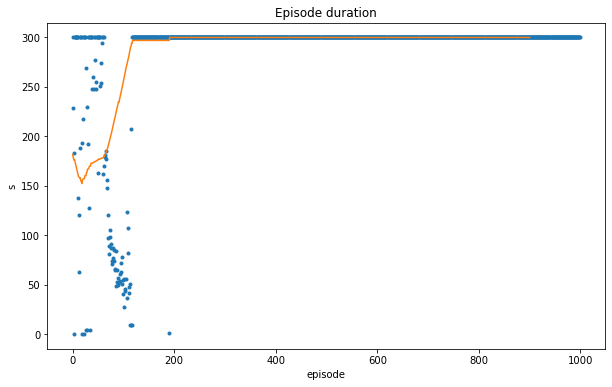

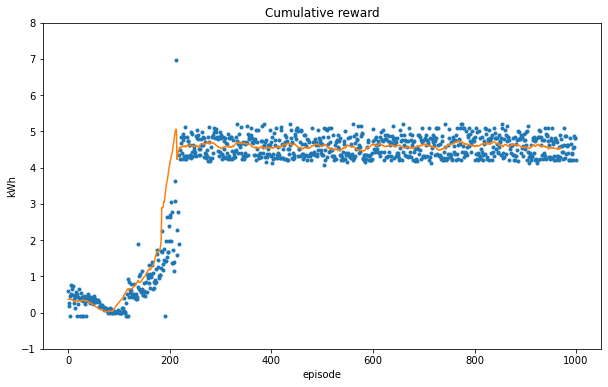

In [133]:
plt.figure(figsize=(10,6))
plt.title("Episode duration")
s_durations=np.array(durations)/5
plt.plot(s_durations, 'o', markersize=3)
plt.plot(np.convolve(s_durations, np.ones(100), 'valid') / 100)
plt.xlabel("episode")
plt.ylabel("s")
plt.savefig("durations.png", bbox_inches='tight', dpi=200)
plt.show()
plt.figure(figsize=(10,6))
kwh_rewards=np.array(rewards)/3.6e1
plt.title("Cumulative reward")
plt.plot(kwh_rewards, 'o', markersize=3)
plt.plot(np.convolve(kwh_rewards, np.ones(30), 'valid') /30)
plt.xlabel("episode")
plt.ylabel("kWh")
plt.ylim((-1,8))
plt.savefig("rewards.png", bbox_inches='tight', dpi=200)
plt.show()

In [41]:
from utils import apply_action

def dql_eval(net, horizon, integration_step, integration_steps_per_learning_step, initial_position, initial_velocity, wind):
    theta=[]
    phi=[]
    r=[]
    net.eval()
    k=pk.kite(initial_position, initial_velocity)
    initial_beta=k.beta()
    S_t=(12,2,initial_beta)
    acc=k.accelerations()
    S_t+=acc
    for i in range(horizon):
        tensor_state=torch.tensor(S_t).float()
        tensor_state[0]/=n_attack
        tensor_state[1]/=n_bank
        tensor_state[2]/=n_beta
        q=net(tensor_state).reshape(3,3)
        #print(torch.max(q))
        print(S_t)
        theta.append(k.position.theta)
        phi.append(k.position.phi)
        r.append(k.position.r)
        A_t=(q==torch.max(q)).nonzero().reshape(-1)
        A_t=A_t[0],A_t[1]
        #print(A_t)
        new_attack_angle, new_bank_angle=apply_action(S_t, A_t)
        status=k.evolve_system(new_attack_angle, new_bank_angle, integration_steps_per_learning_step, integration_step)
        if not status==0:
            print("Simulation failed at learning step: ", i)
            break
        S_t = (new_attack_angle, new_bank_angle, k.beta())
        acc=k.accelerations()
        S_t+=acc
        #visits[S_t]+=1
        if i==int(horizon)-1:
            print( "Simulation ended at learning step: ", i)
    return theta, phi, r

In [ ]:
theta, phi, r=dql_eval(net, horizon, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/6, 0, 50), pk.vect(0, 0, 0), 10)

theta=np.array(theta)
phi=np.array(phi)
r=np.array(r)
x=np.multiply(r, np.multiply(np.sin(theta), np.cos(phi)))
y=np.multiply(r, np.multiply(np.sin(theta), np.sin(phi)))
z=np.multiply(r, np.cos(theta))
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x,y)
plt.figure()
plt.xlabel("x")
plt.ylabel("z")
plt.plot(x,z)
plot_trajectory(theta[::1], phi[::1], r[::1])
plt.figure()
plt.plot(x)
plt.figure()
plt.plot(y)
plt.figure()
plt.plot(z)

In [ ]:
#import sys
factors=[1,2,4,8]
runs=3
episodes=1000
gamma=1
eps0=0.01
eta0=0.1
episode_duration=300
learning_step=0.2
horizon=int(episode_duration/learning_step)
integration_step=0.001
integration_steps_per_learning_step=int(learning_step/integration_step)

for f in factors:
    run_params=[]
    count=0
    while True:
        #print("p")
        net=NN5(f)
        #save_stdout = sys.stdout
        #sys.stdout = open('trash', 'w')
        durations, rewards=dql5(net, episodes, horizon, learning_step, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/6, 0, 50), pk.vect(0, 0, 0), pk.vect(10, 0, 0), lr_decay_start=150000, eps_decay_start=200000, verbose=False)
        #sys.stdout = save_stdout
        print(f," ", durations[-10:])
        if np.mean(np.array(durations[-10:]))>1200:
            count+=1
            for i, param in enumerate(net.parameters()):
                if i==0:
                    param_list=torch.flatten(param).detach().numpy()
            run_params.append(param_list)
            if count==3:
                torch.save(net.state_dict(), 'model%d.pt'%f)
                break
    run_params=np.array(run_params)
    run_params=np.mean(run_params, axis=0)
    plt.figure()
    plt.hist(run_params, bins=np.arange(-20,14)*3, density=True)
    plt.show()
    print(run_params.shape)